# Soccer result predict project

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as scipy
import matplotlib.pyplot as plt
import requests #download from football data
import io 
from __future__ import division
import seaborn as sns
%matplotlib inline

## Load the data

We use the data from the soccer data website http://www.football-data.co.uk.
We downloaded the season 2016/2017 England Premier League data including every game during the season.
And we saved it into the folder named mydata.csv

In [2]:
data1617link = "http://www.football-data.co.uk/mmz4281/1617/E0.csv"

In [3]:
data1617 = requests.get(data1617link).content
df=pd.read_csv(io.StringIO(data1617.decode('utf-8')))
df.to_csv("./mydata/E0_1617.csv")

In [4]:
df = pd.read_csv("./mydata/E0_1617.csv")

The names of columns are shwon in the link.http://www.football-data.co.uk/notes.txt

In [5]:
df.head(5)

,Unnamed: 0,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,0,E0,13/08/16,Burnley,Swansea,0,1,A,0,0,...,1.61,32,-0.25,2.13,2.06,1.86,1.81,2.79,3.16,2.89
1,1,E0,13/08/16,Crystal Palace,West Brom,0,1,A,0,0,...,1.52,33,-0.50,2.07,2.00,1.90,1.85,2.25,3.15,3.86
2,2,E0,13/08/16,Everton,Tottenham,1,1,D,1,0,...,1.77,32,0.25,1.91,1.85,2.09,2.00,3.64,3.54,2.16
3,3,E0,13/08/16,Hull,Leicester,2,1,H,1,0,...,1.67,31,0.25,2.35,2.26,2.03,1.67,4.68,3.50,1.92
4,4,E0,13/08/16,Man City,Sunderland,2,1,H,1,0,...,2.48,34,-1.50,1.81,1.73,2.20,2.14,1.25,6.50,14.50


## Select the attributes we want to use.

The website is for betting. So many attributes above are for the people who like betting. But we are only interested in the information about the games. We just remove all the attributes we will not use.

In [6]:
res_16 = df[['Unnamed: 0', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG',
       'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF',
       'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']]
table_features = df[['Unnamed: 0', 'HomeTeam', 'AwayTeam',]]
bet_16 = df[['B365H', 'B365D', 'B365A',
       'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH',
       'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'Bb1X2',
       'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA', 'BbOU',
       'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5', 'BbAv<2.5', 'BbAH', 'BbAHh',
       'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA', 'PSCH', 'PSCD', 'PSCA']]

In [7]:
res_16.head(5)

,Unnamed: 0,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,0,Burnley,Swansea,0,1,A,0,0,D,J Moss,...,3,9,10,14,7,4,3,2,0,0
1,1,Crystal Palace,West Brom,0,1,A,0,0,D,C Pawson,...,4,3,12,15,3,6,2,2,0,0
2,2,Everton,Tottenham,1,1,D,1,0,H,M Atkinson,...,6,4,10,14,5,6,0,0,0,0
3,3,Hull,Leicester,2,1,H,1,0,H,M Dean,...,5,5,8,17,5,3,2,2,0,0
4,4,Man City,Sunderland,2,1,H,1,0,H,R Madley,...,4,3,11,14,9,6,1,2,0,0


In [8]:
feature_table = df[['Unnamed: 0', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG',
       'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF',
       'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']]

In [9]:
res_16.tail()

,Unnamed: 0,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
375,375,Liverpool,Middlesbrough,3,0,H,1,0,H,M Atkinson,...,10,3,13,8,3,3,0,1,0,0
376,376,Man United,Crystal Palace,2,0,H,2,0,H,A Taylor,...,2,1,16,10,3,6,2,0,0,0
377,377,Southampton,Stoke,0,1,A,0,0,D,L Probert,...,6,3,12,10,4,10,2,4,0,0
378,378,Swansea,West Brom,2,1,H,0,1,A,M Dean,...,2,5,8,10,7,4,1,1,0,0
379,379,Watford,Man City,0,5,A,0,4,A,J Moss,...,3,9,12,10,4,5,1,0,0,0


In [10]:
#Team, Home Goals Score, Away Goals Score, Attack Strength, Home Goals Conceded, Away Goals Conceded, Defensive Strength
table_16 = pd.DataFrame(columns=('Team','HGS','AGS','HAS','AAS','HGC','AGC','HDS','ADS',))
table_16 = table_16[:-10]

In [11]:
res_16 = res_16[:-10]
res_16.shape[0]

370

In [12]:
avg_home_scored_16 = res_16.FTHG.sum()*1.0 / res_16.shape[0]
avg_away_scored_16 = res_16.FTAG.sum()*1.0 / res_16.shape[0]
avg_home_conceded_16 = avg_away_scored_16
avg_away_conceded_16 = avg_home_scored_16
print("Average number of goals at home",avg_home_scored_16)
print("Average number of goals away", avg_away_scored_16)
print("Average number of goals conceded at home",avg_home_conceded_16)
print("Average number of goals conceded away",avg_away_conceded_16)

Average number of goals at home 1.5918918918918918
Average number of goals away 1.1837837837837837
Average number of goals conceded at home 1.1837837837837837
Average number of goals conceded away 1.5918918918918918


In [13]:
res_home = res_16.groupby('HomeTeam')
res_away = res_16.groupby('AwayTeam')

In [14]:
list(res_home)[0]

('Arsenal',
      Unnamed: 0 HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
 7             7  Arsenal       Liverpool     3     4   A     1     1   D   
 30           30  Arsenal     Southampton     2     1   H     1     1   D   
 50           50  Arsenal         Chelsea     3     0   H     3     0   H   
 70           70  Arsenal         Swansea     3     2   H     2     1   H   
 80           80  Arsenal   Middlesbrough     0     0   D     0     0   D   
 105         105  Arsenal       Tottenham     1     1   D     1     0   H   
 126         126  Arsenal     Bournemouth     3     1   H     1     1   D   
 140         140  Arsenal           Stoke     3     1   H     1     1   D   
 170         170  Arsenal       West Brom     1     0   H     0     0   D   
 188         188  Arsenal  Crystal Palace     2     0   H     1     0   H   
 217         217  Arsenal         Burnley     2     1   H     0     0   D   
 220         220  Arsenal         Watford     1     2   A     0 

In [15]:
table_16.Team = res_home.HomeTeam.all().values
table_16.HGS = res_home.FTHG.sum().values
table_16.HGC = res_home.FTAG.sum().values
table_16.AGS = res_away.FTAG.sum().values
table_16.AGC = res_away.FTHG.sum().values

In [16]:
#Assuming number of home games = number of away games
num_games = res_16.shape[0]/20

In [17]:
table_16.HAS = (table_16.HGS / num_games) / avg_home_scored_16
table_16.AAS = (table_16.AGS / num_games) / avg_away_scored_16
table_16.HDS = (table_16.HGC / num_games) / avg_home_conceded_16
table_16.ADS = (table_16.AGC / num_games) / avg_away_conceded_16
table_16

,Team,HGS,AGS,HAS,AAS,HGC,AGC,HDS,ADS
0,Arsenal,36,38,1.222411,1.735160,15,28,0.684932,0.950764
1,Bournemouth,35,19,1.188455,0.867580,29,37,1.324201,1.256367
2,Burnley,25,13,0.848896,0.593607,18,35,0.821918,1.188455
3,Chelsea,50,30,1.697793,1.369863,16,16,0.730594,0.543294
4,Crystal Palace,24,26,0.814941,1.187215,25,36,1.141553,1.222411
5,Everton,42,19,1.426146,0.867580,16,25,0.730594,0.848896
6,Hull,27,9,0.916808,0.410959,28,45,1.278539,1.528014
7,Leicester,30,17,1.018676,0.776256,24,38,1.095890,1.290323
8,Liverpool,42,33,1.426146,1.506849,18,24,0.821918,0.814941
9,Man City,37,38,1.256367,1.735160,17,22,0.776256,0.747029


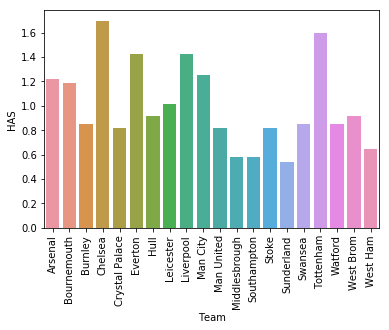

In [18]:
has_plot = sns.barplot(table_16.Team,table_16.HAS)
for item in has_plot.get_xticklabels():
    item.set_rotation(90)

In [19]:
table_16[table_16.Team == "Chelsea"]

,Team,HGS,AGS,HAS,AAS,HGC,AGC,HDS,ADS
3,Chelsea,50,30,1.697793,1.369863,16,16,0.730594,0.543294


In [20]:
''' feature_table contains all the fixtures in the current season.
ftr = full time result
hst = home shots on target
ast = away shots on target
'''

feature_table = feature_table[['HomeTeam','AwayTeam','FTR','HST','AST']]
f_HAS = []
f_HDS = []
f_AAS = []
f_ADS = []
for index,row in feature_table.iterrows():
    f_HAS.append(table_16[table_16['Team'] == row['HomeTeam']]['HAS'].values[0])
    f_HDS.append(table_16[table_16['Team'] == row['HomeTeam']]['HDS'].values[0])
    f_AAS.append(table_16[table_16['Team'] == row['AwayTeam']]['AAS'].values[0])
    f_ADS.append(table_16[table_16['Team'] == row['AwayTeam']]['ADS'].values[0])
    
feature_table['HAS'] = f_HAS
feature_table['HDS'] = f_HDS
feature_table['AAS'] = f_AAS
feature_table['ADS'] = f_ADS

In [21]:
feature_table.head(20)

,HomeTeam,AwayTeam,FTR,HST,AST,HAS,HDS,AAS,ADS
0,Burnley,Swansea,A,3,9,0.848896,0.821918,0.821918,1.222411
1,Crystal Palace,West Brom,A,4,3,0.814941,1.141553,0.684932,0.916808
2,Everton,Tottenham,D,6,4,1.426146,0.730594,1.461187,0.543294
3,Hull,Leicester,H,5,5,0.916808,1.278539,0.776256,1.290323
4,Man City,Sunderland,H,4,3,1.256367,0.776256,0.547945,1.018676
5,Middlesbrough,Stoke,D,2,1,0.577250,1.050228,0.730594,1.086587
6,Southampton,Watford,D,6,1,0.577250,0.913242,0.684932,1.324278
7,Arsenal,Liverpool,A,5,7,1.222411,0.684932,1.506849,0.814941
8,Bournemouth,Man United,A,3,7,1.188455,1.324201,1.278539,0.577250
9,Chelsea,West Ham,H,6,3,1.697793,0.730594,1.187215,1.086587


In [22]:
def transformResult(row):
    '''Converts results (H,A or D) into numeric values'''
    if(row.FTR == 'H'):
        return 1
    elif(row.FTR == 'A'):
        return -1
    else:
        return 0

In [23]:
feature_table["Result"] = feature_table.apply(lambda row: transformResult(row),axis=1)

In [24]:
feature_table = feature_table[:-10] #ONLY FOR WEEK 33. REMOVE FROM 34
feature_table.tail(10)

,HomeTeam,AwayTeam,FTR,HST,AST,HAS,HDS,AAS,ADS,Result
360,Stoke,Arsenal,A,4,6,0.814941,1.095890,1.735160,0.950764,-1
361,Sunderland,Swansea,A,4,3,0.543294,1.552511,0.821918,1.222411,-1
362,Crystal Palace,Hull,H,4,0,0.814941,1.141553,0.410959,1.528014,1
363,Tottenham,Man United,H,7,2,1.595925,0.410959,1.278539,0.577250,1
364,West Ham,Liverpool,A,3,11,0.645161,1.415525,1.506849,0.814941,-1
365,Chelsea,Watford,H,9,3,1.697793,0.730594,0.684932,1.324278,1
366,Arsenal,Sunderland,H,13,2,1.222411,0.684932,0.547945,1.018676,1
367,Man City,West Brom,H,10,2,1.256367,0.776256,0.684932,0.916808,1
368,Southampton,Man United,D,6,1,0.577250,0.913242,1.278539,0.577250,0
369,Leicester,Tottenham,A,5,12,1.018676,1.095890,1.461187,0.543294,-1


In [25]:
X_train = feature_table[['HST','AST','HAS','HDS','AAS','ADS',]]
y_train = feature_table['Result']

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import voting_classifier
from sklearn.svm import LinearSVC

In [27]:
clf1 = RandomForestClassifier()
clf4 = LinearSVC()

In [28]:
y_pred = clf4.fit(X_train,y_train).predict(X_train)
accuracy_score(y_pred,y_train)
scores = cross_val_score(clf1, X_train, y_train, cv=10)
print(scores)
print(scores.mean())

[ 0.58974359  0.56410256  0.52631579  0.43243243  0.56756757  0.61111111
  0.5         0.72222222  0.63888889  0.61111111]
0.576349527665


## Adding Recent Performance

In [29]:
#What is this for?
ht = res_16.loc[40].HomeTeam
at = res_16.loc[40].AwayTeam

In [30]:
feat_table = res_16.sort_index(ascending=False)
feat_table = feat_table[['HomeTeam','AwayTeam','FTR','FTHG','FTAG','HS','AS','HC','AC']]

In [31]:
# Adding next week fixtures
new_fixtures = pd.DataFrame( [['West Ham','Arsenal','D',0,0,0,0,0,0],
                             ['Liverpool','West Brom','D',0,0,0,0,0,0],
                             ['Man United','Bournemouth','D',0,0,0,0,0,0],
                             ['Tottenham','Middlesbrough','D',0,0,0,0,0,0],
                             ['Swansea','Man City','D',0,0,0,0,0,0],
                             ['Sunderland','Everton','D',0,0,0,0,0,0],
                             ['Southampton','Leicester','D',0,0,0,0,0,0],
                             ['Hull','Chelsea','D',0,0,0,0,0,0],
                             ['Crystal Palace','Watford','D',0,0,0,0,0,0],
                             ['Burnley','Stoke','D',0,0,0,0,0,0]],columns=feat_table.columns)

In [32]:
new_feat_table = new_fixtures.append(feat_table,ignore_index=True)
new_feat_table = new_feat_table.sort_index(ascending=False)
new_feat_table = new_feat_table.reset_index().drop(['index'], axis=1)
new_feat_table = new_feat_table.sort_index(ascending=False)
# feat_table = n
feat_table = new_feat_table
feat_table.shape

(380, 9)

In [33]:
#Adding k recent performance measures
feat_table["pastHS"] = 0.0
feat_table["pastHC"] = 0.0
feat_table["pastAS"] = 0.0
feat_table["pastAC"] = 0.0
feat_table["pastHG"] = 0.0
feat_table["pastAG"] = 0.0

In [73]:
feat_table.head(10)

,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HS,AS,HC,AC,pastHS,pastHC,pastAS,pastAC,pastHG,pastAG,HAS,HDS,AAS,ADS
379,West Ham,Arsenal,D,0,0,0,0,0,0,18.666667,4.000000,10.000000,10.666667,0.333333,2.666667,0.645161,1.415525,1.187215,1.086587
378,Liverpool,West Brom,D,0,0,0,0,0,0,7.666667,3.333333,19.666667,5.666667,1.666667,1.000000,1.426146,0.821918,1.506849,0.814941
377,Man United,Bournemouth,D,0,0,0,0,0,0,13.333333,6.666667,15.000000,4.333333,0.333333,1.666667,0.814941,0.547945,1.278539,0.577250
376,Tottenham,Middlesbrough,D,0,0,0,0,0,0,11.000000,5.000000,19.000000,6.000000,2.666667,1.000000,1.595925,0.410959,1.461187,0.543294
375,Swansea,Man City,D,0,0,0,0,0,0,11.000000,7.333333,6.333333,8.333333,1.333333,3.333333,0.848896,1.506849,0.821918,1.222411
374,Sunderland,Everton,D,0,0,0,0,0,0,18.333333,10.666667,11.333333,6.666667,0.666667,0.333333,0.543294,1.552511,0.547945,1.018676
373,Southampton,Leicester,D,0,0,0,0,0,0,12.000000,7.000000,19.000000,7.666667,0.666667,1.666667,0.577250,0.913242,1.095890,0.916808
372,Hull,Chelsea,D,0,0,0,0,0,0,11.666667,5.333333,6.000000,7.000000,0.000000,2.666667,0.916808,1.278539,0.410959,1.528014
371,Crystal Palace,Watford,D,0,0,0,0,0,0,14.666667,8.666667,16.666667,9.000000,1.333333,1.000000,0.814941,1.141553,1.187215,1.222411
370,Burnley,Stoke,D,0,0,0,0,0,0,14.666667,8.666667,11.333333,4.000000,1.666667,1.000000,0.848896,0.821918,0.593607,1.188455


In [35]:
# Adding k recent performance metrics. Change value of k.
k = 3
for i in range(feat_table.shape[0]-1,-1,-1):
    row = feat_table.loc[i]
    ht = row.HomeTeam
    at = row.AwayTeam
    ht_stats = feat_table.loc[i-1:-1][(feat_table.HomeTeam == ht) | (feat_table.AwayTeam == ht)].head(k)
    at_stats = feat_table.loc[i-1:-1][(feat_table.HomeTeam == at) | (feat_table.AwayTeam == at)].head(k)

    feat_table.set_value(i, 'pastHC', (ht_stats[ht_stats["AwayTeam"] == ht].sum().HC + ht_stats[ht_stats["HomeTeam"] == ht].sum().HC)/k)
    feat_table.set_value(i, 'pastAC', (at_stats[at_stats["AwayTeam"] == at].sum().HC + at_stats[at_stats["HomeTeam"] == at].sum().HC)/k)
    feat_table.set_value(i, 'pastHS', (ht_stats[ht_stats["AwayTeam"] == ht].sum().HS + ht_stats[ht_stats["HomeTeam"] == ht].sum().AS)/k)
    feat_table.set_value(i, 'pastAS', (at_stats[at_stats["AwayTeam"] == at].sum().HS + at_stats[at_stats["HomeTeam"] == at].sum().AS)/k)
    feat_table.set_value(i, 'pastHG', (ht_stats[ht_stats["AwayTeam"] == ht].sum().FTAG + ht_stats[ht_stats["HomeTeam"] == ht].sum().FTHG)/k)
    feat_table.set_value(i, 'pastAG', (at_stats[at_stats["AwayTeam"] == at].sum().FTAG + at_stats[at_stats["HomeTeam"] == at].sum().FTHG)/k)

f_HAS = []
f_HDS = []
f_AAS = []
f_ADS = []
for index,row in feat_table.iterrows():
    #print (row)
    f_HAS.append(table_16[table_16['Team'] == row['HomeTeam']]['HAS'].values[0])
    f_HDS.append(table_16[table_16['Team'] == row['HomeTeam']]['HDS'].values[0])
    f_AAS.append(table_16[table_16['Team'] == row['HomeTeam']]['AAS'].values[0])
    f_ADS.append(table_16[table_16['Team'] == row['HomeTeam']]['ADS'].values[0])
    
feat_table['HAS'] = f_HAS
feat_table['HDS'] = f_HDS
feat_table['AAS'] = f_AAS
feat_table['ADS'] = f_ADS

/Users/mengzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/mengzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [36]:
test_table = feat_table.drop(['FTHG','FTAG','HS','AS','HC','AC'],axis=1)

In [37]:
test_table["Result"] = test_table.apply(lambda row: transformResult(row),axis=1)
test_table.sort_index(inplace=True)

In [38]:
# num_games decides the train-test split
print(feat_table.shape)
num_games = feat_table.shape[0]-10
num_games

(380, 19)


370

In [39]:
X_train = test_table[['pastHS','pastHC','pastAS','pastAC','pastHG','pastAG','HAS','HDS','AAS','ADS']].loc[0:num_games]
y_train = test_table['Result'].loc[0:num_games]
X_test = test_table[['pastHS','pastHC','pastAS','pastAC','pastHG','pastAG','HAS','HDS','AAS','ADS']].loc[num_games:]
y_test = test_table['Result'].loc[num_games:]

In [57]:
y_pred = clf4.fit(X_train,y_train).predict(X_test)
accuracy_score(y_pred,y_test)
scores = cross_val_score(clf1, X_train, y_train, cv=10)
print(scores)
print(scores.mean())

[ 0.54054054  0.37837838  0.52777778  0.27777778  0.41666667  0.57142857
  0.42857143  0.48571429  0.42857143  0.41176471]
0.446719156131


# Adding home advantage

In [41]:
test_table["pastCornerDiff"] = (test_table["pastHC"] - test_table["pastAC"])/k
test_table["pastGoalDiff"] = (test_table["pastHG"] - test_table["pastAG"])/k
test_table["pastShotsDiff"] = (test_table["pastHS"] - test_table["pastAG"])/k

In [42]:
''' number of games to exclude in the training set for validation
For example, if 240 games have been played, test_table has 250 fixtures - the last 10 being the ones that haven't
been played. So, we set aside 20 fixtures from the training set containing 240 fixtures for validation.''' 
num_games = feat_table.shape[0]-10
print(num_games)
v_split = 15
n_games = num_games - v_split

370


In [43]:
test_table.head()

,HomeTeam,AwayTeam,FTR,pastHS,pastHC,pastAS,pastAC,pastHG,pastAG,HAS,HDS,AAS,ADS,Result,pastCornerDiff,pastGoalDiff,pastShotsDiff
0,Burnley,Swansea,A,0.0,0.0,0.0,0.0,0.0,0.0,0.848896,0.821918,0.593607,1.188455,-1,0.0,0.0,0.0
1,Crystal Palace,West Brom,A,0.0,0.0,0.0,0.0,0.0,0.0,0.814941,1.141553,1.187215,1.222411,-1,0.0,0.0,0.0
2,Everton,Tottenham,D,0.0,0.0,0.0,0.0,0.0,0.0,1.426146,0.730594,0.867580,0.848896,0,0.0,0.0,0.0
3,Hull,Leicester,H,0.0,0.0,0.0,0.0,0.0,0.0,0.916808,1.278539,0.410959,1.528014,1,0.0,0.0,0.0
4,Man City,Sunderland,H,0.0,0.0,0.0,0.0,0.0,0.0,1.256367,0.776256,1.735160,0.747029,1,0.0,0.0,0.0


In [44]:
test_table.drop(['pastHC','pastAS','pastAC','pastHG','pastAG'],axis=1)
X_train = test_table[['pastCornerDiff','pastGoalDiff','pastShotsDiff','HAS','HDS','AAS','ADS']].loc[0:n_games]
y_train = test_table['Result'].loc[0:n_games]
X_test = test_table[['pastCornerDiff','pastGoalDiff','pastShotsDiff','HAS','HDS','AAS','ADS']].loc[n_games:num_games-1]
y_test = test_table['Result'].loc[n_games:num_games-1]
X_predict = test_table[['pastCornerDiff','pastGoalDiff','pastShotsDiff','HAS','HDS','AAS','ADS']].loc[num_games:]

In [45]:
X_predict

,pastCornerDiff,pastGoalDiff,pastShotsDiff,HAS,HDS,AAS,ADS
370,1.555556,0.222222,4.555556,0.848896,0.821918,0.593607,1.188455
371,-0.111111,0.111111,4.555556,0.814941,1.141553,1.187215,1.222411
372,-0.555556,-0.888889,3.000000,0.916808,1.278539,0.410959,1.528014
373,-0.222222,-0.333333,3.444444,0.577250,0.913242,1.095890,0.916808
374,1.333333,0.111111,6.000000,0.543294,1.552511,0.547945,1.018676
375,-0.333333,-0.666667,2.555556,0.848896,1.506849,0.821918,1.222411
376,-0.333333,0.555556,3.333333,1.595925,0.410959,1.461187,0.543294
377,0.777778,-0.444444,3.888889,0.814941,0.547945,1.278539,0.577250
378,-0.777778,0.222222,2.222222,1.426146,0.821918,1.506849,0.814941
379,-2.222222,-0.777778,5.333333,0.645161,1.415525,1.187215,1.086587


In [46]:
# clf1.fit(X_train,y_train)
# #clf2.fit(X_train,y_train)
# clf3.fit(X_train,y_train)
# clf4.fit(X_train,y_train)
# clf5.fit(X_train,y_train)
# clf6.fit(X_train,y_train)

In [58]:
#Logistic Regression
plot_scores_logreg= []
cs = [0.01,0.02,0.1,0.5,1,3,4,5,10]
for c in cs:
    clf_logreg = LogisticRegression(C=c,solver='lbfgs',multi_class='ovr')
    clf_logreg.fit(X_train, y_train)
    scores = accuracy_score(y_test,clf_logreg.predict(X_test))
    plot_scores_logreg.append(scores)


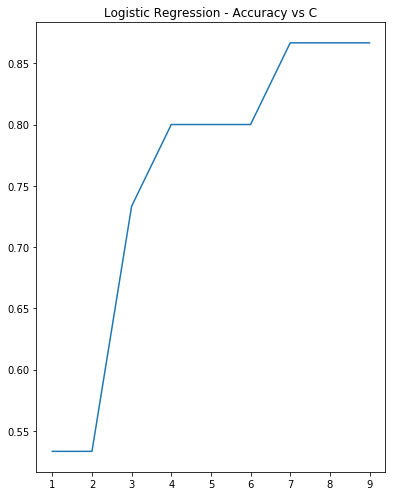

In [60]:
fig = plt.figure(figsize = (16,7))
# plt.style.use('ggplot')


ax3 = fig.add_subplot(1,3,3)
ax3.plot(range(1,10),plot_scores_logreg);
ax3.set_xticks(range(1,10));
ax3.set_title("Logistic Regression - Accuracy vs C")

fig.tight_layout()

In [62]:
max_logreg_c = max(plot_scores_logreg)
max_logreg_ind = plot_scores_logreg.index(max_logreg_c)
print(max_logreg_c, max_logreg_ind)

0.866666666667 6


In [63]:
clf_logreg = LogisticRegression(C=max_logreg_ind,solver='lbfgs',multi_class='ovr').fit(X_train,y_train)

In [64]:
y_pred_logreg = clf_logreg.predict(X_predict)

In [65]:
this_week = test_table[['HomeTeam','AwayTeam']].loc[num_games:]

this_week['Result_logreg']=y_pred_logreg

In [66]:
this_week

,HomeTeam,AwayTeam,Result_logreg
370,Burnley,Stoke,1
371,Crystal Palace,Watford,1
372,Hull,Chelsea,-1
373,Southampton,Leicester,-1
374,Sunderland,Everton,-1
375,Swansea,Man City,-1
376,Tottenham,Middlesbrough,1
377,Man United,Bournemouth,1
378,Liverpool,West Brom,1
379,West Ham,Arsenal,-1


In [67]:
def transformResultBack(row,col_name):
    if(row[col_name] == 1):
        return 'H'
    elif(row[col_name] == -1):
        return 'A'
    else:
        return 'D'

In [69]:
this_week["Res_logreg"] = this_week.apply(lambda row: transformResultBack(row,"Result_logreg"),axis=1)

this_week.drop(["Result_logreg"],axis=1,inplace=True)

In [72]:
print(max_logreg_c)
this_week

0.866666666667


,HomeTeam,AwayTeam,Res_logreg
370,Burnley,Stoke,H
371,Crystal Palace,Watford,H
372,Hull,Chelsea,A
373,Southampton,Leicester,A
374,Sunderland,Everton,A
375,Swansea,Man City,A
376,Tottenham,Middlesbrough,H
377,Man United,Bournemouth,H
378,Liverpool,West Brom,H
379,West Ham,Arsenal,A
